# 环境配置

In [1]:
# !nvidia-smi
import torch
print(torch.__version__)
torch.cuda.set_device(0)

2.2.1+cu121


In [2]:
# 连接网盘
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
%cd drive/MyDrive/detectron2
%ls

/content/drive/MyDrive/detectron2
 018_Color.png            leaf_000001.jpg                            plant_output_video.mp4
 1.jpg                    leaf_color_000000.png                      pre.jpg
 3.jpg                    leaf_color_000001.png                      road/
 balloon/                 __MACOSX/                                  RoadDataset/
 balloon_dataset.zip      maskrcnn-benchmark/                        road_output/
 bean/                    model_final_edd263_pointrend_r50_3lr.pkl   runs/
 bean_masks/             'model_final_f10217 .pkl'                   stop.jpg
 bean_set/                output/                                    temp/
 box_disease/             output2.mp4                                Test_1010.jpg
 coco_eval/               output_cut.mp4                             Test_1357.jpg
 color2.png               panopticapi/                               test2.mp4
 cow/                     panoptic_images/                           Test_41.jpg
 det

In [4]:
!pip install opencv-python opencv-python-headless
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-f5vmrh_m
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-f5vmrh_m
  Resolved https://github.com/facebookresearch/detectron2.git to commit a59f05630a8f205756064244bf5beb8661f96180
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6147767 sha256=91b37a75e91db6300c6f3c74a3d

# 实例分割训练过程

## 数据集注册

In [5]:
from detectron2.data.datasets import register_coco_instances

In [6]:
# 注册new训练集
register_coco_instances("beantrain", {}, "./bean_set/bean_box_data/train/beantrain_coco.json", "./bean_set/bean_box_data/train")

## 配置模型和训练

In [7]:
import os
import numpy as np
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("beantrain",)
cfg.DATASETS.TEST = ()
MetadataCatalog.get("beantrain").set(thing_classes=["leaf"])
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 200    # 300 iterations
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE =  128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  #the number of classes
cfg.OUTPUT_DIR = './output/bean1_mask_rcnn_R_50_FPN_3x_200iter'

In [ ]:
class MyTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
      output_folder = os.path.join(cfg.OUTPUT_DIR,"inference")
    return COCOEvaluator(dataset_name, cfg, True, output_folder)



os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/07 09:03:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 205MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[09/07 09:03:22 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/07 09:03:35 d2.utils.events]:  eta: 0:01:13  iter: 19  total_loss: 4.471  loss_cls: 1.066  loss_box_reg: 0.6522  loss_mask: 0.6938  loss_rpn_cls: 1.888  loss_rpn_loc: 0.1774    time: 0.4157  last_time: 0.4011  data_time: 0.0461  last_data_time: 0.0254   lr: 2.3976e-05  max_mem: 2243M
[09/07 09:03:46 d2.utils.events]:  eta: 0:01:04  iter: 39  total_loss: 2.739  loss_cls: 0.894  loss_box_reg: 0.8626  loss_mask: 0.6779  loss_rpn_cls: 0.1757  loss_rpn_loc: 0.1388    time: 0.4133  last_time: 0.4339  data_time: 0.0078  last_data_time: 0.0054   lr: 4.8951e-05  max_mem: 2244M
[09/07 09:03:55 d2.utils.events]:  eta: 0:00:56  iter: 59  total_loss: 2.392  loss_cls: 0.6639  loss_box_reg: 0.8598  loss_mask: 0.6377  loss_rpn_cls: 0.0921  loss_rpn_loc: 0.1419    time: 0.4157  last_time: 0.3848  data_time: 0.0124  last_data_time: 0.0049   lr: 7.3926e-05  max_mem: 2244M
[09/07 09:04:04 d2.utils.events]:  eta: 0:00:48  iter: 79  total_loss: 2.237  loss_cls: 0.5728  loss_box_reg: 0.8738  loss_mask: 0

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./output/bean1_mask_rcnn_R_50_FPN_3x_200iter

<IPython.core.display.Javascript object>

In [ ]:
!ls -l ./output/bean1_mask_rcnn_R_50_FPN_3x_200iter

total 342890
-rw------- 1 root root     11392 Sep  7 08:48 events.out.tfevents.1694076531.0c6f2d09ca11.206.0
-rw------- 1 root root     11392 Sep  7 08:53 events.out.tfevents.1694076705.0c6f2d09ca11.206.1
-rw------- 1 root root     11392 Sep  7 09:05 events.out.tfevents.1694077418.43078b8a88e6.664.0
-rw------- 1 root root        15 Sep  7 09:05 last_checkpoint
-rw------- 1 root root     22911 Sep  7 09:05 metrics.json
-rw------- 1 root root 351060339 Sep  7 09:05 model_final.pth


In [ ]:
%reload_ext tensorboard

!kill 3585  # 请替换为实际的进程ID，即上面消息中显示的PID

%tensorboard --logdir ./output/bean1_mask_rcnn_R_50_FPN_3x_200iter  # 指定模型保存的目录作为TensorBoard的日志目录

<IPython.core.display.Javascript object>

## 预测图片

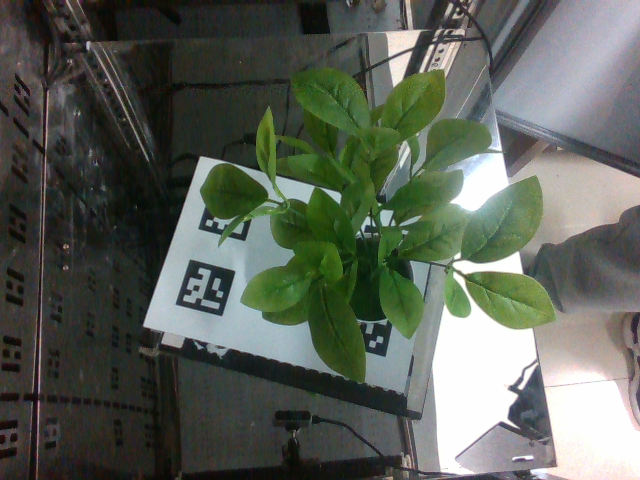

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from detectron2.engine.defaults import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.config import get_cfg
from detectron2 import model_zoo
import time

im = cv2.imread("./018_Color.png")
cv2_imshow(im)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file("./detectron2_dc/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set threshold for this model
cfg.MODEL.WEIGHTS = "./output/bean1_mask_rcnn_R_50_FPN_3x_500iter/model_final.pth"
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
predictor = DefaultPredictor(cfg)
t1=time.time()
outputs = predictor(im)
t2=time.time()
print(t2-t1)

[09/25 02:57:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/bean1_mask_rcnn_R_50_FPN_3x_500iter/model_final.pth ...
0.17024469375610352


In [ ]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
Boxes(tensor([[197.4547, 164.3937, 266.5511, 219.8739],
        [378.1210, 265.0352, 423.1884, 338.8474],
        [306.8587, 187.2675, 353.3297, 251.6479],
        [292.1693, 240.0072, 340.3870, 282.0989],
        [461.7476, 270.7928, 554.8805, 326.9633],
        [269.4170, 201.4193, 314.6795, 249.6552],
        [442.3990, 267.1935, 470.3986, 316.8169],
        [421.4541, 117.9063, 491.6234, 168.5929],
        [376.9909,  67.9275, 445.4373, 144.5680],
        [306.9624, 275.4498, 365.4889, 382.3801],
        [380.1182, 170.2859, 463.4965, 212.6401],
        [277.3615, 151.8312, 352.7976, 188.7084],
        [290.1200,  65.0366, 371.4484, 137.0871],
        [237.9840, 263.7888, 319.9665, 310.4119],
        [393.7124, 204.9821, 471.6978, 264.0463],
        [457.9341, 174.7180, 545.3301, 263.1000],
        [301.5363, 108.4952, 338.3874, 156.0490],
        [380.6170, 139.9967, 413.0764, 201.92

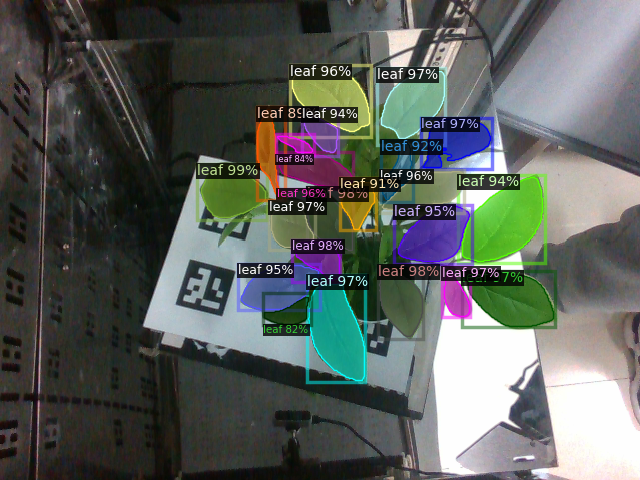

In [ ]:
# 创建自定义的 MetadataCatalog
my_metadata = MetadataCatalog.get("my_dataset")
my_metadata.set(thing_classes=["leaf"])  # 设置自定义的类别名称列表

v = Visualizer(im[:, :, ::-1], my_metadata, scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
out_frame=out.get_image()[:, :, ::-1]
cv2_imshow(out_frame)

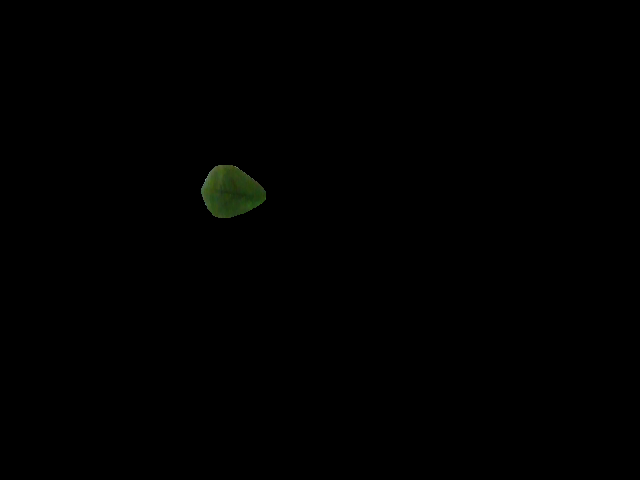

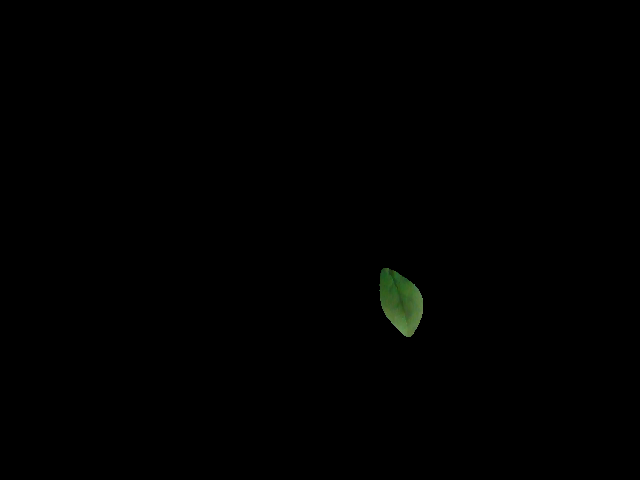

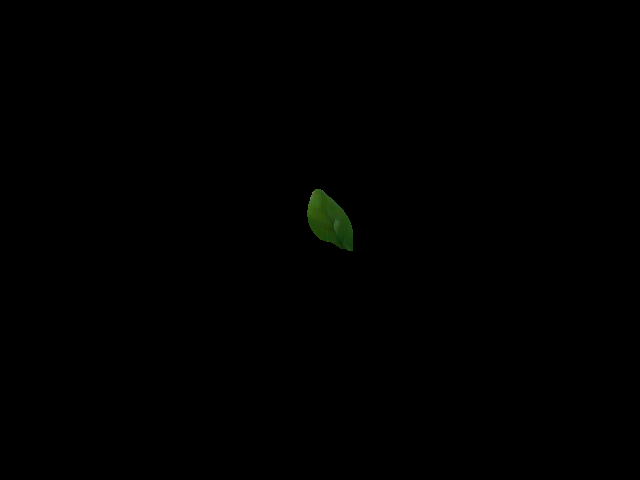

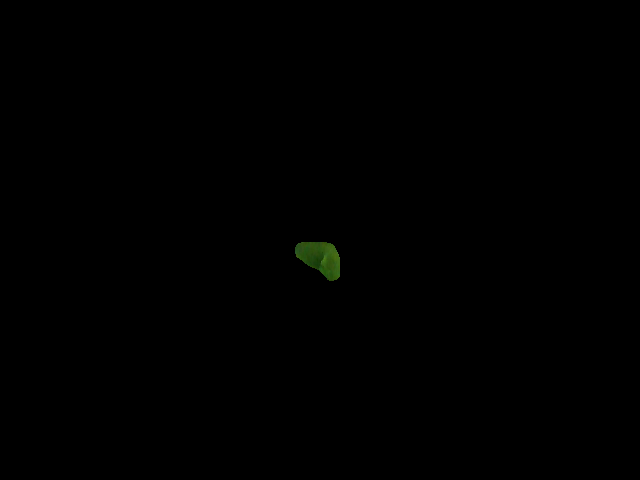

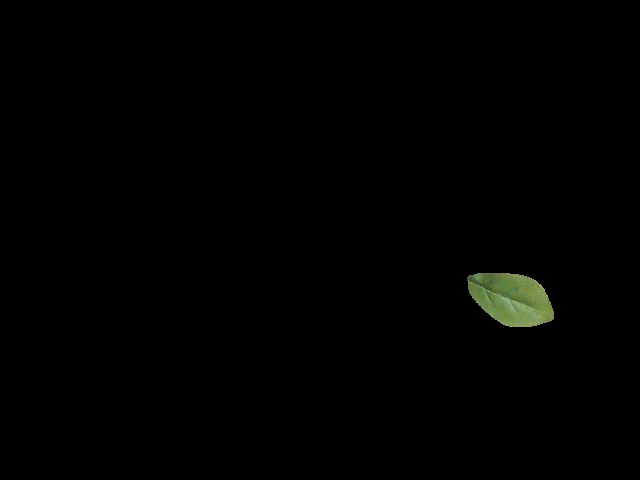

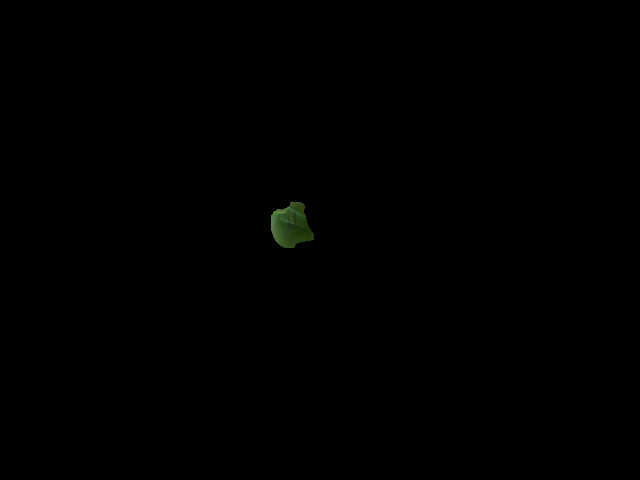

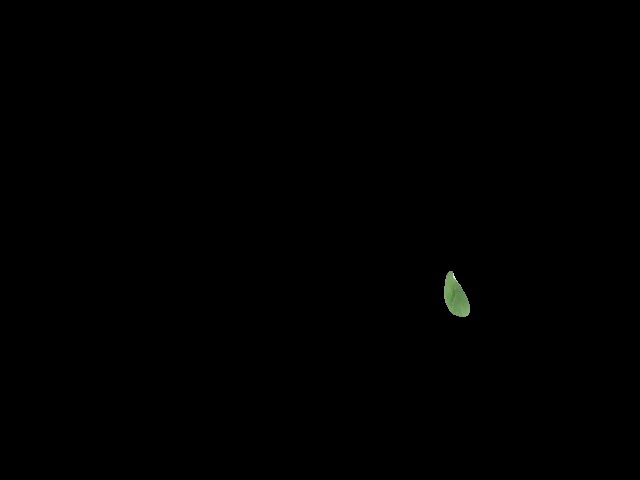

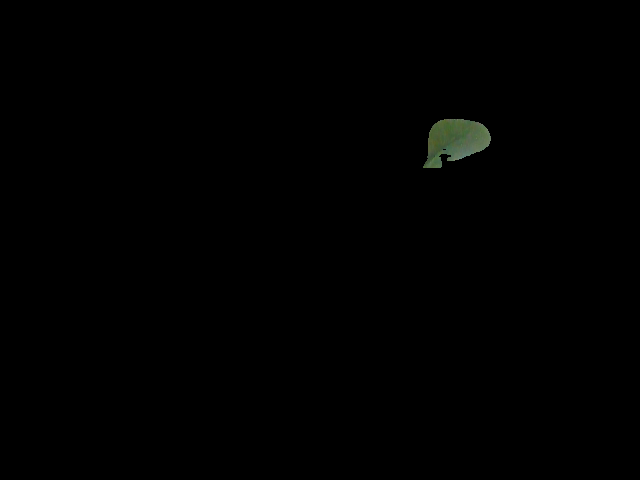

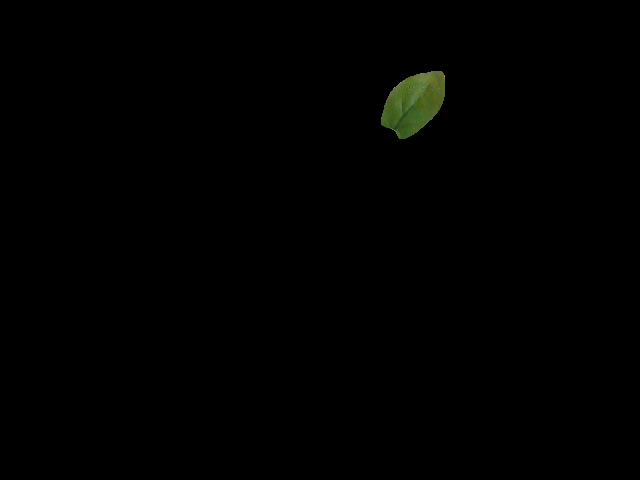

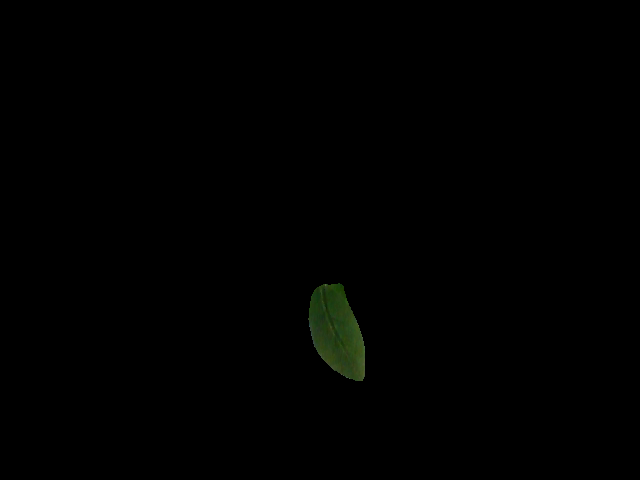

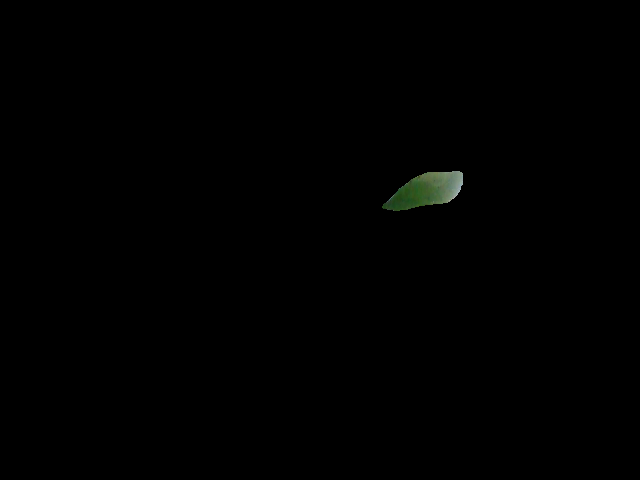

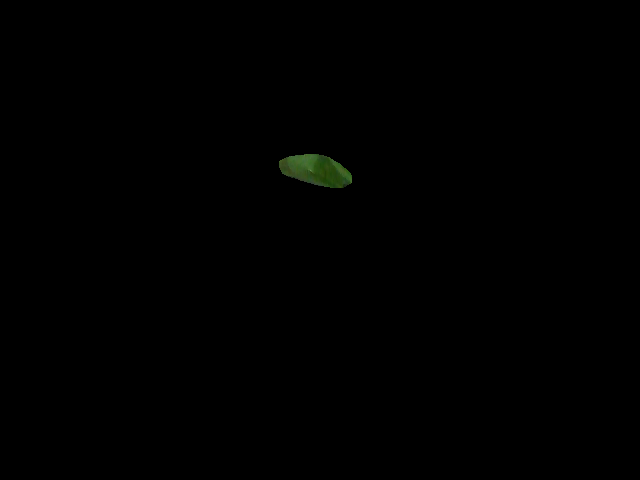

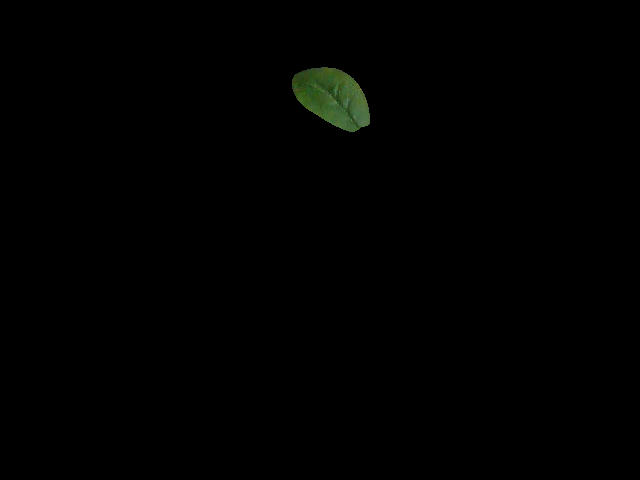

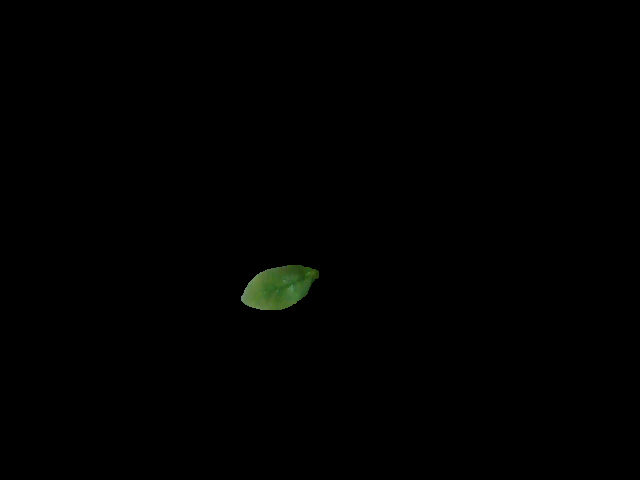

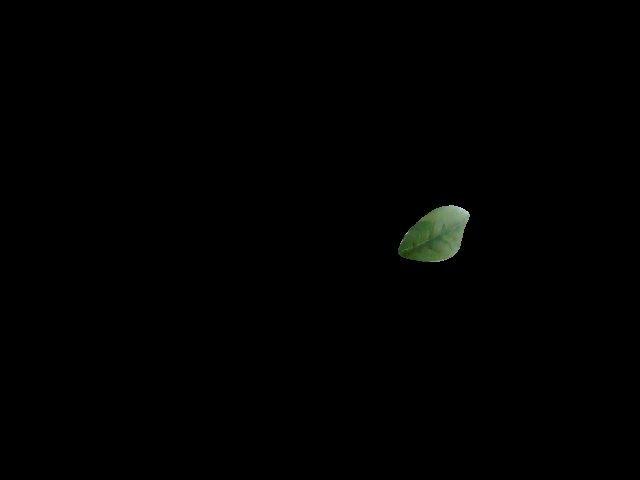

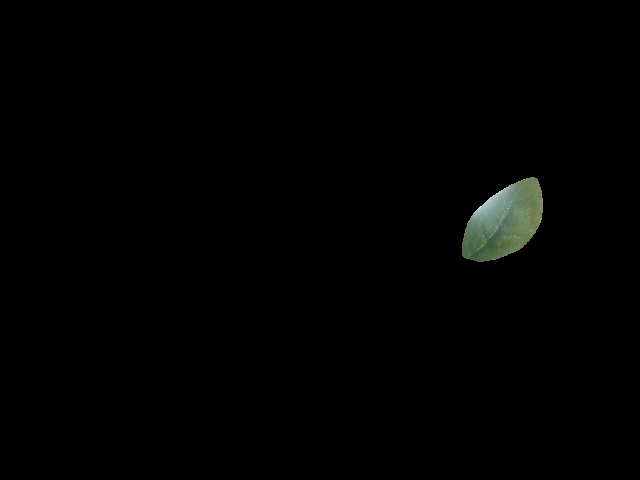

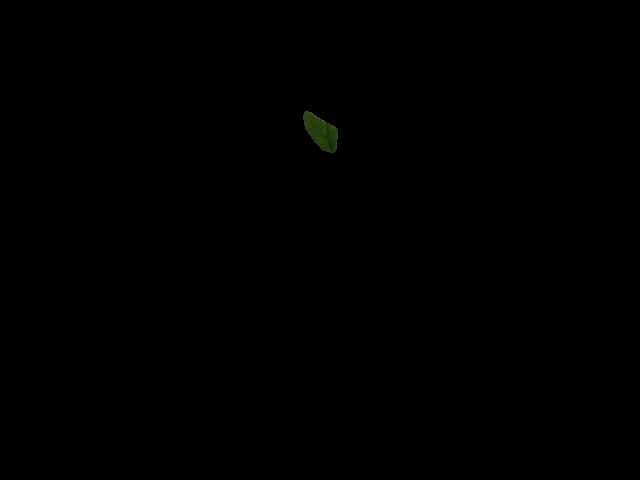

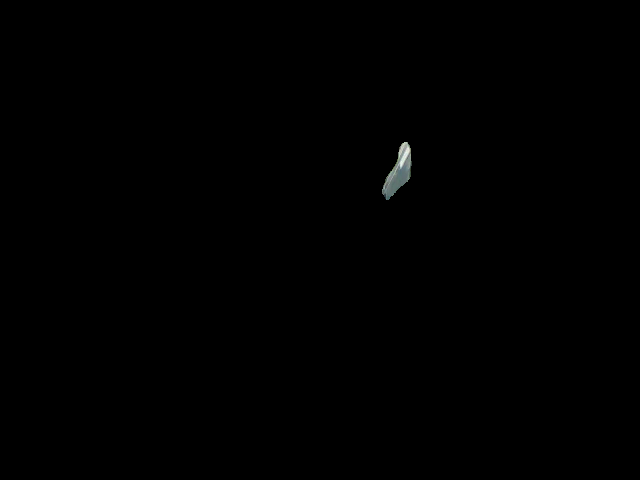

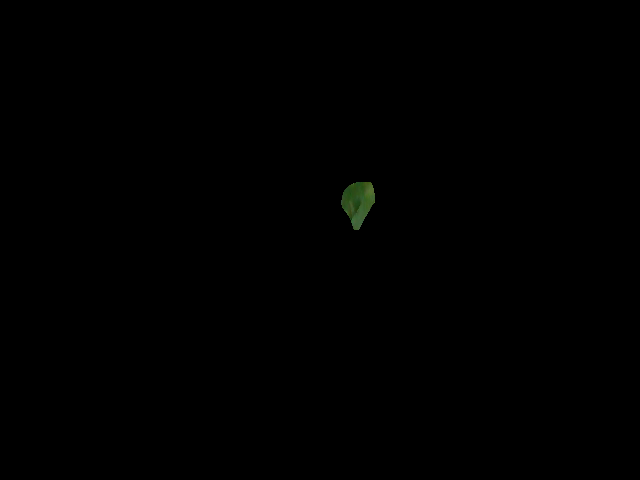

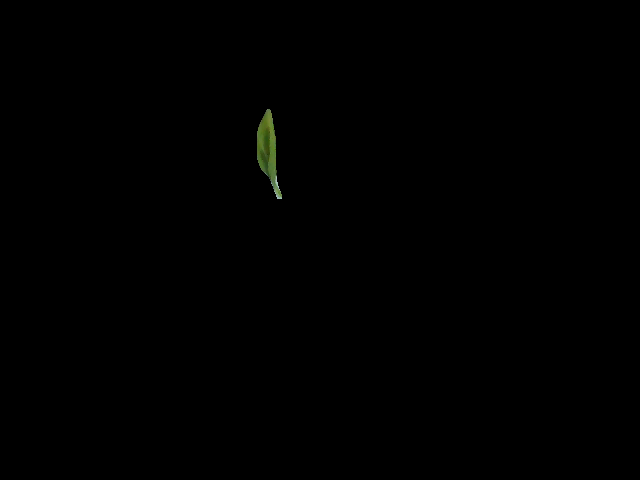

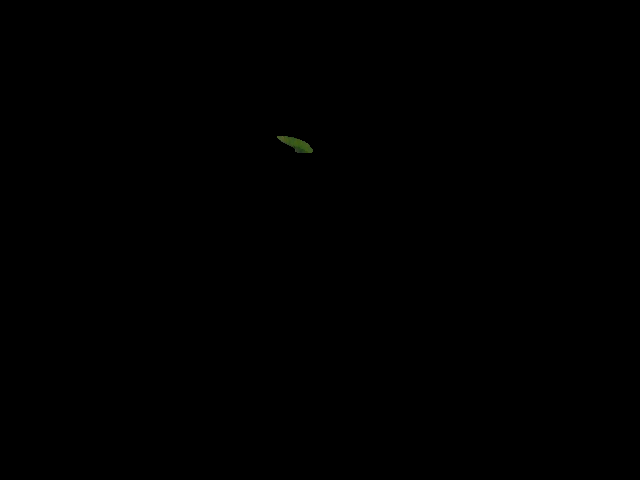

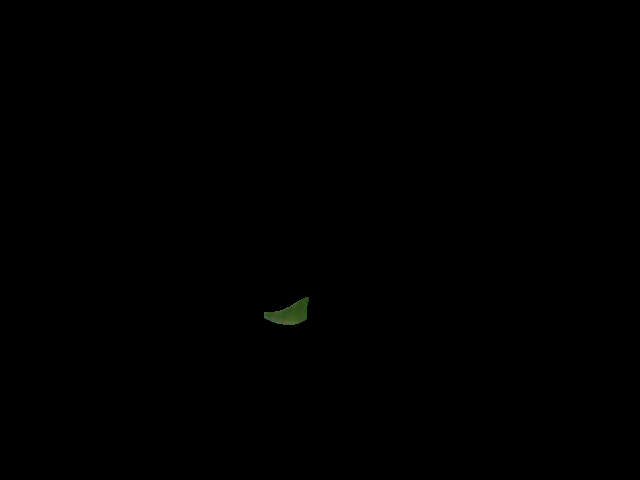

In [ ]:
#以下可以用在对视频或者所有叶片进行出图的时候使用
masks = outputs["instances"].to("cpu").pred_masks.detach().numpy()
for idx, mask in enumerate(masks):
    mask = (mask * 255).astype(np.uint8)
    mask = cv2.merge([mask, mask, mask])

    # 使用掩码与原始图像相交，得到实例分割结果图像
    result = cv2.bitwise_and(im, mask)
    cv2_imshow(result)

## 实例分割一个图像并处理出图每一个叶片的掩码图

In [ ]:
import detectron2
import numpy as np
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo

import os
import cv2
from os import listdir
from os.path import isfile, join

# 创建配置对象并加载预训练的模型配置
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

print('网络模型构建成功')

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 两个类别，包括背景
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.WEIGHTS = "./output/bean1_mask_rcnn_R_50_FPN_3x_500iter/model_final.pth"  # 读取已经训练好的网络模型参数

print('网络参数读取成功')

predictor = DefaultPredictor(cfg)

print('创建预测器')

imgPath = './bean_set/bean3_test/'
maskPath = './bean_set/bean3_output/'
onlyfiles = [f for f in listdir(imgPath) if isfile(join(imgPath, f))]

print(listdir(imgPath))
print(onlyfiles)

for iter in range(len(onlyfiles)):
    fileName = imgPath + onlyfiles[iter]
    print('fileName: ', fileName)
    newDir = os.path.splitext(onlyfiles[iter])[0]

    # 创建保存掩码图的文件夹
    os.makedirs(maskPath + newDir, exist_ok=True)
    maskDir = maskPath + newDir + '/'
    print('maskDir: ', maskDir)

    im = cv2.imread(fileName)
    outputs = predictor(im)

    masks = outputs["instances"].to("cpu").pred_masks.detach().numpy()

    for idx, mask in enumerate(masks):
        maskName = maskDir + "sub_" + str(idx) + ".png"
        print('maskName: ', maskName);
        mask = (mask * 255).astype(np.uint8)
        mask = cv2.merge([mask, mask, mask])

        # 使用掩码与原始图像相交，得到实例分割结果图像
        result = cv2.bitwise_and(im, mask)
        cv2.imwrite(maskName, result)
        print("写入", maskName)

网络模型构建成功
网络参数读取成功
[09/06 09:29:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/bean1_mask_rcnn_R_50_FPN_3x_500iter/model_final.pth ...
创建预测器
['017_Color.png']
['017_Color.png']
fileName:  ./bean_set/bean3_test/017_Color.png
maskDir:  ./bean_set/bean3_output/017_Color/
maskName:  ./bean_set/bean3_output/017_Color/sub_0.png
写入 ./bean_set/bean3_output/017_Color/sub_0.png
maskName:  ./bean_set/bean3_output/017_Color/sub_1.png
写入 ./bean_set/bean3_output/017_Color/sub_1.png
maskName:  ./bean_set/bean3_output/017_Color/sub_2.png
写入 ./bean_set/bean3_output/017_Color/sub_2.png
maskName:  ./bean_set/bean3_output/017_Color/sub_3.png
写入 ./bean_set/bean3_output/017_Color/sub_3.png
maskName:  ./bean_set/bean3_output/017_Color/sub_4.png
写入 ./bean_set/bean3_output/017_Color/sub_4.png
maskName:  ./bean_set/bean3_output/017_Color/sub_5.png
写入 ./bean_set/bean3_output/017_Color/sub_5.png
maskName:  ./bean_set/bean3_output/017_Color/sub_6.png
写入 ./bean_set/bean3_output